## <center> ПРОЕКТ-4
### <center> Подготовка рекомендательной системы

<div style="text-align: right"> Студент группы: DAPR-206 </div>
<div style="text-align: right"> Смирнов А.С. </div>

### Библиотеки

In [33]:
##Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import itertools
import psycopg2.extras
from operator import itemgetter, attrgetter
from collections import defaultdict
import matplotlib.pyplot as plt

### Выгружаем данные:

In [34]:
#Запрос для получения данных (id подьзователей и купленых курсов)
query = """with users as (
    select 
    c.user_id,  
    count(distinct(i.resource_id)) as courses_num  
    from final.cart_items i 
    left join final.carts c on i.cart_id = c.id 
    where c.state = 'successful'and i.resource_type = 'Course'
    group by c.user_id) 
    select 
    distinct c.user_id,  
    i.resource_id 
    from final.cart_items i 
    left join final.carts c on i.cart_id = c.id 
    where c.state = 'successful' and i.resource_type = 'Course' and c.user_id in (
        select user_id from users where courses_num > 1)"""
conn=psycopg2.connect(
        "dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
dict_cur=conn.cursor(cursor_factory=psycopg2.extras.DictCursor)      
dict_cur.execute(query)
rows=dict_cur.fetchall()

# Создаем DF(users_course_df) с id пользователей и купленых курсов
users_course_df = pd.DataFrame(rows, columns=('Users_id', 'Course_id'))

"""Т.к. Среди курсов есть один курс который не покупался в паре с другими курсами. 
Поэтому для получения полного списка курсов мы делаем отдельный запрос"""

# Функция для выгрузки данные о списоке курсов
def get_data():    
    query="""SELECT DISTINCT Resource_ID
    FROM final.cart_items
    WHERE Resource_Type='Course'"""
    conn=psycopg2.connect(
    "dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur=conn.cursor(cursor_factory=psycopg2.extras.DictCursor)      
    dict_cur.execute(query)
    rows=dict_cur.fetchall()
    course_list = list()
    for row in rows:
        course_list.append(row[0])
    return course_list

# Выгружаем данные из базы по запросу список курсов
course_list=get_data() # Список уникальных курсов
print('Всего курсов:', len(course_list))

Всего курсов: 127


### Анализ полученных данных:

In [35]:
# Определяем DF(users_course_groups_df) со списком курсов купленных каждым пользователем
users_course_groups_df = users_course_df.groupby('Users_id').agg({'Course_id':list}).reset_index()

# находим комбинации курсов
course_combinations = list()
for i in users_course_groups_df['Course_id']:
    for y in itertools.combinations(sorted(i), 2):
        course_combinations.append(y)
course_combinations

# Подсчитываем сколько раз купили каждую пару курсов
pair_dict = dict()
pair_list = list()
for i in course_combinations:
    if i in pair_list:
        pair_dict[i]+=1
    else:
        pair_dict[i]=1
        pair_list.append(i)

# находим самую популярную пару(top)
max_value = max(pair_dict.values())
top = list(pair_dict.keys())[list(pair_dict.values()).index(max_value)]
print("Самая популярная пара курсов:", top)

# создаем DF (pair_df) с парами и их частотность
pair_df = pd.DataFrame(pair_dict.items())

# Видим сколько всего различных купленых комбинаций курсов
pair_df=pair_df.rename(columns={0:'pair', 1:'count'})
pair_df.info()


Самая популярная пара курсов: (551, 566)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3989 entries, 0 to 3988
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pair    3989 non-null   object
 1   count   3989 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.5+ KB


### Выбор минимальной границы для частотности рекомендации

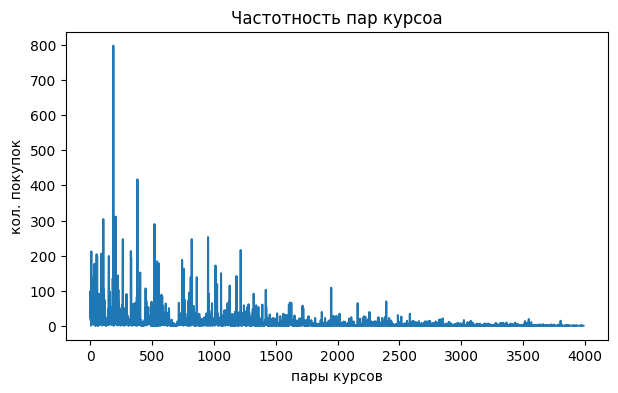

Значение ниже которого в рекомендательной таблице будет предлагаться другой (более популярный) курс: 15


In [36]:
# Строим график для визуального восприятия
plt.figure(figsize=(7,4))
# Использовал построение по индексу что-бы не перестраивать таблицу (т.к. pair_df['pair'] представляет собой список)
plt.plot(pair_df.index, pair_df['count'])
plt.xlabel('пары курсов')
plt.ylabel('кол. покупок')
plt.title('Частотность пар курсоа')
plt.show()

"""Из графика 'Частотность пар курсоа' видно что есть явный выброс самая популярная пара курсов,
так же там видно что абсалютное большенство пар не дотягивают даже отметки в 100 покупок.
Поэтому нужно выбрать высокий процентель для границы рекомендации я думаю в диапазоне от 80 до 90. 
Я возьму середину данного диапазона 85. Но в реальной практике я предпочел бы сперва провести пару 
консультаций с коллегами из других отделов (что бы лучше понимать взаимосвязь курсов в парах) перед 
принятием данного решения"""

# определяем процентель
minimum = np.percentile(pair_df['count'], 85)
print("Значение ниже которого в рекомендательной таблице будет предлагаться другой (более популярный) курс:", round(minimum))

### Рекомендательная функция

In [ ]:
# Функция с рекомендациями
""" В данном примере функция  выводит помимо id курса ещё и значение с его частотой для наглядности и простаты проверки результатов"""
recom=defaultdict(list)
def recommendation(list):
    for course in list:
        for id, value in pair_dict.items():
            if course == id[0]:
                recom[course].append([id[1],value])
            elif course == id[1]:
                recom[course].append([id[0],value])
            recom[course].sort(key= lambda x: x[1],reverse = True)
                    
    recom_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in recom.items() ]))
    recom_df = recom_df.iloc[:2]
    
    for i in recom_df:
        # Даём рекомендацию к курсу который не покупали в паре
        if recom_df[i][0] is np.nan:
            recom_df[i][0] = [top[0],0]
        if recom_df[i][1] is np.nan:
            recom_df[i][1] = [top[1],0]
        # Даём рекомендацию к курсам пары которых именют низкую частотность
        if recom_df[i][0][1] < minimum:
            recom_df[i][0][0] =top[0]
        if recom_df[i][1][1] < minimum:
            recom_df[i][1][0] =top[1]
    return recom_df

# рекомендательная таблица с частотностью
recommendation_df = recommendation(course_list)

C:\Users\User\AppData\Local\Temp\ipykernel_7892\979780571.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  recom_df[i][0] = [top[0],0]
C:\Users\User\AppData\Local\Temp\ipykernel_7892\979780571.py:21: FutureWarning: ChainedAssignmentError

In [38]:
# Именуем столбцы рекомендательной таблицы
recommendation_df = recommendation_df.transpose()
recommendation_df = recommendation_df.rename(columns={0:'recommendation 1', 1:'recommendation 2'})
recommendation_df.index.names=['Curs ID']

### Функция оставляющая только ID курса

In [39]:
# Функция котора оставляет только ID курса
def ID_curs(table):
    id_dict=defaultdict(list)
    for i in table.index:
        id_dict[i].append(table.loc[i,'recommendation 1'][0])
        id_dict[i].append(table.loc[i,'recommendation 2'][0])
    id_df = pd.DataFrame(id_dict)
    return id_df

recommendation_table = ID_curs(recommendation_df)
# Именуем столбцы рекомендательной таблицы
recommendation_table = recommendation_table.transpose()
recommendation_table = recommendation_table.rename(columns={0:'recommendation 1', 1:'recommendation 2'})
recommendation_table.index.names=['Curs ID']
print(recommendation_table.head(5))

         recommendation 1  recommendation 2
Curs ID                                    
809                   490               570
1145                  840               569
908                  1100               809
814                   564               551
1181                  752               566


### <center> Рекомендательная таблица

In [ ]:
"""Я решил предоставить два варианта т.к. по таблице с частотность наверно будет удобнее ориентироваться при проверки работы"""
# код позволяет увидеть таблицу целиком
pd.set_option('display.max_rows', None)
# рекомендательная таблица с частотность
print(recommendation_df.head(3))

        recommendation 1 recommendation 2
Curs ID                                  
809           [490, 163]       [570, 119]
1145           [840, 29]        [569, 18]
908           [1100, 36]        [809, 32]


In [41]:
# рекомендательная таблица только с ID курсов
recommendation_table

,recommendation 1,recommendation 2
Curs ID,,
809,490,570
1145,840,569
908,1100,809
814,564,551
1181,752,566
753,750,551
765,571,1125
1102,1100,1103
1156,551,566
